# ML Summer School Assignment 4

This assignment is divided into 2 parts, in the first part you guys will be implementing Kmeans clustering from scratch without the use of any machine learning libraries like sklearn for the task of document clustering and the second part (probably more interesting :P) will guide you to make a recommender system of your own!

## Task 1

This task features clustering sysnopses of Top 100 movies as rated by IMdB. The task is to identify movies that fall into the same genre using an usupervised approach such as K-Means clustering to cluster movies whose synopses refer to similar structures.

### Load Libraries
These libraries will be needed to complete this task. While you'll have most of them already installed if you have followed the previous assignments, you can easily install the rest by googling (:D) 

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn import feature_extraction
import pickle
import scipy

### Load data
The ratings are taken from IMdB and synopses scraped from IMdB and Wikipedia (we have already done this for you) and stored as pickled lists, you can always take a look at them to get a better feel of the data.

In [2]:
titles=pickle.load(open('data/titles.pkl','rb'))
links=pickle.load(open('data/links.pkl','rb'))
genres=pickle.load(open('data/genres.pkl','rb'))
ranks=pickle.load(open('data/ranks.pkl','rb'))
synopses=pickle.load(open('data/synopses.pkl','rb'))
print(len(titles),len(links),len(genres),len(ranks),len(synopses))

100 100 100 100 100


### Heads Up!
Before you move forward, you'll have to download 2 NLTK packages, namely, stopwords and punkt in order to do the required preprocessing of synopses.
To download them, just run the cell below, press 'd', type the names of the packages and you're good to go! :)

In [3]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

### Sub Task 1 -  Preprocessing the Data
You'll have to preprocess the data in this sub-task. Mainly, we'll be removing stopwords, tokenizing and stemming.

1. You already know about stopwords from your previous assignments. Stop words are words like "a", "the", or "in" which don't convey significant meaning. You can read more about them [here](https://en.wikipedia.org/wiki/Stop_words)

2. Stemming is the process of breaking the  word down to its root form. More [here](http://en.wikipedia.org/wiki/Stemming). We will be using the [Snowball Stemmer](http://snowball.tartarus.org/) which is part of the NLTK package.

3. Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens. Tokenization plays a large part in the process of lexical analysis. We will be using NLTK's inbuilt tokennizer. More [here](https://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize)

In [4]:
#load english language stopwords from nltk and store it in the list stopwords 
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
#import the snoball stemmer and create a stemmer object for the english language
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Your task starts here, fill in the two functions, namely, `tokenize_and_stem()` and `tokenize_only()`. 
* The first function returns a nested list of stemmed tokens. You'll have to filter out the tokens which do not contain any letters. Particularly return the list `stems`, `ith` entry of which contains the stemmed tokens of the `ith` sentence in the given synopses text.
* The second fucntion is similar but in this you only have to return the setence-wise tokens in the list filtered_tokens.

In [6]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that we have sentence wise list of tokens (i.e. a nested list)
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

We create `totalvocab_stemmed` and `totalvocab_tokenized` for all the words in the vocabulary (i.e. all the words in all the synopses combined)

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Create a dataframe `vocab_frame` which contains one to one mapping of all the stemmed words and the original words in the vocabulary. (This will be needed later for visualization purposes)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

### Sub Task 2 - Creating the Features
In this task you will have to create the tfidf matrix which will we used to cluster the given synopses. You have leart about tfidf features from the previous assignments. More about it [here](http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/) and [here](http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/). You can use the `TfidfVectorizer` provided by sklearn.
Store the matrix in the variable `tfidf_matrix`.

**A bit about the various parameters you can use to get better features and hence better clusters which using the sklearn tfidfVectorizer.**(This is very very important to get good results)
* max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
* min_df: this could be a proportion (e.g. 0.2) and the term would have to be in at least 20% of the documents to be considered.
* ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

Also, use 'english' for the `stop_words` parameter and `tokenize_and_stem`(the function you wrote) for `tokenizer` parameter in the Vectorizer.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

CPU times: user 7.61 s, sys: 93.8 ms, total: 7.7 s
Wall time: 7.72 s
(100, 563)


### Sub Task 3 - Implementing KMeans

This is the most important sub-task of this task because in this, you will implement your own K-Means. Fill in the function `KMeans` which will return the labels and cluster centers in the tuple `(labels,centers)` for the given feature matrix `X` and `num_clusters`. We also pass the `max_iter` parameter to run KMeans for that many iterations as it sometimes gets stuck on a local minima. You can learn more about Kmeans clustering [here](https://en.wikipedia.org/wiki/K-means_clustering) and [here](https://www.datascience.com/blog/k-means-clustering).

In [10]:
def Kmeans(X, num_clusters=8, max_iter=300):
    n_data_points=X.shape[0]
    n_dimensions=X.shape[1]
    np.random.seed(42)
    centers=X[np.random.choice(X.shape[0], num_clusters, replace=False), :]
    labels=np.zeros(n_data_points)
    for z in range(max_iter):
        for i,x in enumerate(X):
            min_dist=1e12
            for j,center in enumerate(centers):
                dist=np.linalg.norm(np.subtract(x,center))
                if dist<min_dist:
                    min_dist=dist
                    labels[i]=j
        for i,center in enumerate(centers):
            centers[i][:]=np.mean(X[np.unique(np.where(labels==i)[0]), :], axis=0)
    return (labels, centers)

Fit the computed tf-idf matrix using the function written above to obtain the labels and the centers. You can play with different number of centers and maximum iterations to get different results.

In [11]:
%time (labels,centers)=Kmeans(tfidf_matrix.todense(), num_clusters=5, max_iter=1000)

CPU times: user 7.84 s, sys: 15.6 ms, total: 7.86 s
Wall time: 7.91 s


Create a dataframe `frame` that stores the the clusters labels, names and genres for all the 100 movies.

In [12]:
import pandas as pd
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': labels, 'genre': genres }
frame = pd.DataFrame(films, index = [labels] , columns = ['rank', 'title', 'cluster', 'genre'])
frame

,rank,title,cluster,genre
2.0,0,The Godfather,2.0,"[u' Crime', u' Drama']"
2.0,1,The Shawshank Redemption,2.0,"[u' Crime', u' Drama']"
4.0,2,Schindler's List,4.0,"[u' Biography', u' Drama', u' History']"
2.0,3,Raging Bull,2.0,"[u' Biography', u' Drama', u' Sport']"
0.0,4,Casablanca,0.0,"[u' Drama', u' Romance', u' War']"
3.0,5,One Flew Over the Cuckoo's Nest,3.0,[u' Drama']
4.0,6,Gone with the Wind,4.0,"[u' Drama', u' Romance', u' War']"
4.0,7,Citizen Kane,4.0,"[u' Drama', u' Mystery']"
1.0,8,The Wizard of Oz,1.0,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
4.0,9,Titanic,4.0,"[u' Drama', u' Romance']"


Movie counts for a particular cluster.

In [13]:
frame['cluster'].value_counts()

4.0    27
1.0    22
3.0    19
2.0    19
0.0    13
Name: cluster, dtype: int64

### Visualizing Results
Sort the cluster centers to get the most important terms per cluster and store it in `cluster_names`. Also print them along with the movies in that cluster to get a feel of the clusters you have made with your KMeans.

In [14]:
print("Top terms per cluster:")
order_centroids = np.asarray(centers).argsort()[:, ::-1]
cluster_names=[]
for i in range(5):
    print("Cluster %d words:" % i, end='')
    q=[]
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        q.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_names.append(q)
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:
Cluster 0 words: b'mr.', b'singing', b'music', b'john', b'perform', b'love',
Cluster 0 titles: Casablanca, Vertigo, 2001: A Space Odyssey, Singin' in the Rain, Amadeus, The Good, the Bad and the Ugly, The Deer Hunter, The Green Mile, Nashville, The African Queen, A Clockwork Orange, Wuthering Heights, Yankee Doodle Dandy,

Cluster 1 words: b'killed', b'soldiers', b'men', b'town', b'shoot', b'arrives',
Cluster 1 titles: The Wizard of Oz, Lawrence of Arabia, The Silence of the Lambs, The Bridge on the River Kwai, Apocalypse Now, Gladiator, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Ben-Hur, Jaws, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, High Noon, Dances with Wolves, All Quiet on the Western Front, The Grapes of Wrath, Shane, Close Encounters of the Third Kind, The Maltese Falcon, Taxi Driver,

Cluster 2 words: b'car', b'george', b'father', b'brothers', b'police', b'family',
Cluster 2 titles: The Godfather, The S

### Plotting the Data
Now we plot the various movies.
Basically we scale the multi-dimentional feature vector using Multi-dimentional scaling using the the cosine distance between the tf-idf, vectors. That is, we find the cosine distance between every pair of n-dimentional vectors and scale it to 2 dimensions so that they can be plotted in a plane. More about it [here](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) and [here](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html).

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [16]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names_plt = {0: cluster_names[0], 
                 1: cluster_names[1], 
                 2: cluster_names[2], 
                 3: cluster_names[3], 
                 4: cluster_names[4]}

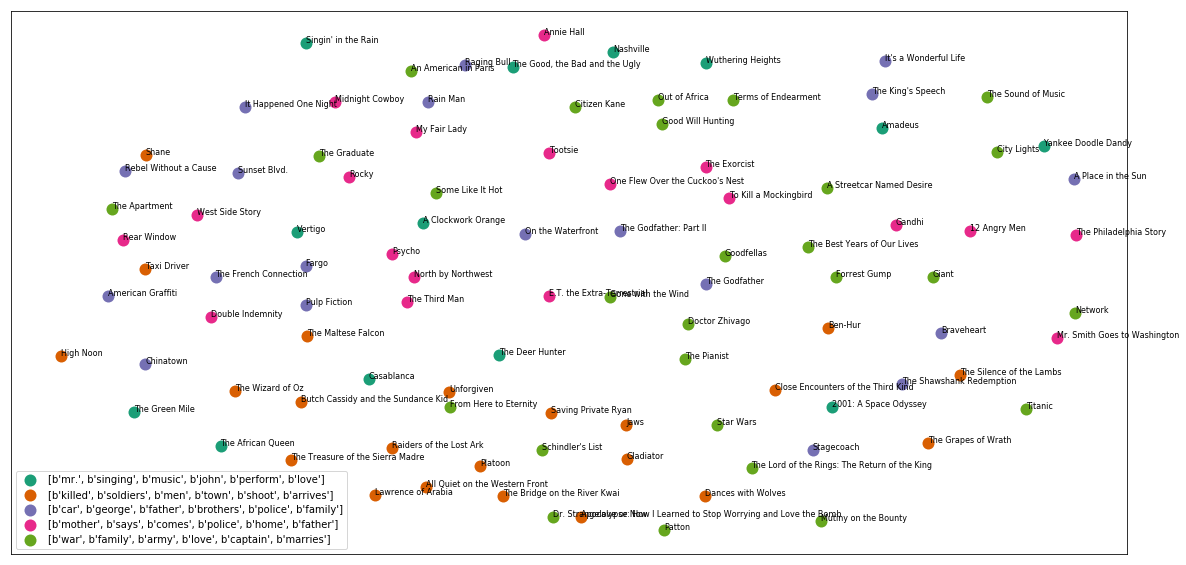

In [17]:
%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=labels, title=titles)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names_plt[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

# And Part 1 is Over!